In [1]:
import numpy as np
data_path = "/Users/waelbenslima/Desktop/data/phione1.txt"
data = np.loadtxt(data_path)
data_reshaped = data.reshape((1331, 171, 171))

In [3]:
data_path1 = "/Users/waelbenslima/Desktop/data/phitwo1.txt"
data1 = np.loadtxt(data_path1)
data_reshaped1 = data1.reshape((1331, 171, 171))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

# Load data
phi2 = data_reshaped1.reshape((1331, 171, 171, 1))  # Shape: (1331, 171, 171, 1) (phi2)
phi1 = data_reshaped.reshape((1331, 171, 171, 1))  # Shape: (1331, 171, 171, 1) (phi1)

# Normalize data
phi2_norm = phi2 / np.max(phi2)
phi1_norm = phi1 / np.max(phi1)

# Define function to generate random masks with sparsity
def generate_random_mask(shape, sparsity):
    mask = np.random.choice([0, 1], size=shape, p=[sparsity, 1 - sparsity])
    return mask

# Define function to add noise
def add_noise(data, sigma):
    # Add noise: (1 + u(0, sigma)) * data
    noise = np.random.normal(0, sigma, data.shape)
    noisy_data = data * (1 + noise)
    return noisy_data

# Apply masks to phi2 data
sparsity = 0.8
masks = np.array([generate_random_mask(phi2_norm[0].shape, sparsity) for _ in range(len(phi2_norm))])
phi2_masked = phi2_norm * masks

# Add noise with different sigma values
sigma_values = [0.01, 0.05, 0.1]
noisy_phi2 = {}

for sigma in sigma_values:
    print(f"Adding noise with sigma = {sigma}")
    noisy_phi2[sigma] = add_noise(phi2_masked, sigma)

# Split into training and testing sets
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    phi2_masked, phi1_norm, masks, test_size=0.2, random_state=42
)

# Define the CNN model for reconstruction
input_shape = (171, 171, 1)
mask_input_shape = (171, 171, 1)

phi2_input = layers.Input(shape=input_shape, name="phi2_input")
mask_input = layers.Input(shape=mask_input_shape, name="mask_input")

# Combine masked input
masked_phi2 = layers.Multiply()([phi2_input, mask_input])

# CNN model for reconstruction
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(masked_phi2)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Cropping to handle dimensional mismatch
output = layers.Cropping2D(cropping=((0, 1), (0, 1)))(output)

# Create the model
model = models.Model(inputs=[phi2_input, mask_input], outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Adding noise with sigma = 0.01
Adding noise with sigma = 0.05
Adding noise with sigma = 0.1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ phi2_input          │ (None, 171, 171,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 171, 171,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 171, 171,  │          0 │ phi2_input[0][0], │
│                     │ 1)                │            │ mask_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 171, 171,  │        320 │ multiply[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 86, 86,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 86, 86,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 43, 43,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 43, 43,    │     36,928 │ max_pooling2d_1[… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 86, 86,    │          0 │ conv2d_transpose… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 86, 86,    │     18,464 │ up_sampling2d[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 172, 172,  │          0 │ conv2d_transpose… │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 172, 172,  │        289 │ up_sampling2d_1[… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping2d          │ (None, 171, 171,  │          0 │ conv2d_2[0][0]    │
│ (Cropping2D)        │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 598ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 581ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 616ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 581ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 731ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 744ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 638ms/step - loss: 0.0011 - val_loss: 9.4039e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 667ms/step - loss: 9.8299e-04 - val_loss: 9.0086e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 631ms/step - loss: 8.7624e-04 - val_loss: 7.9229e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 660ms/step - loss: 7.8756e-04 - val_loss: 7.4821e-04
Epoch 12/20
3

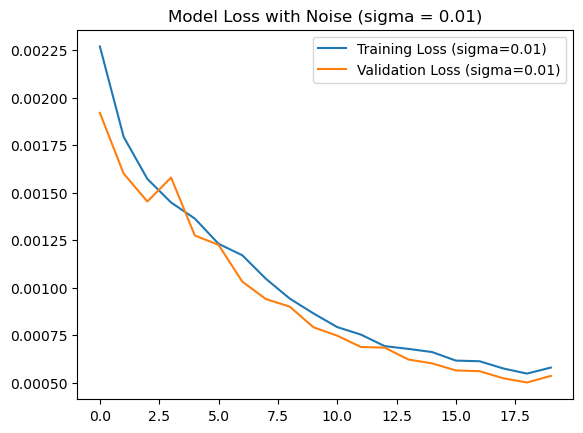

In [11]:
# Add noise with sigma = 0.01 to phi2 data
sigma = 0.01
noisy_phi2_001 = add_noise(phi2_masked, sigma)

# Split into training and testing sets for noisy data
X_train_001, X_test_001, y_train_001, y_test_001, masks_train_001, masks_test_001 = train_test_split(
    noisy_phi2_001, phi1_norm, masks, test_size=0.2, random_state=42
)

# Train the model
history_001 = model.fit(
    [X_train_001, masks_train_001], y_train_001,
    validation_data=([X_test_001, masks_test_001], y_test_001),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history_001.history['loss'], label='Training Loss (sigma=0.01)')
plt.plot(history_001.history['val_loss'], label='Validation Loss (sigma=0.01)')
plt.legend()
plt.title("Model Loss with Noise (sigma = 0.01)")
plt.show()


In [15]:
# Predict the output for the noisy input (sigma = 0.01)
predicted_phi1_001 = model.predict([X_test_001, masks_test_001])

# Calculate and display the metrics
def calculate_metrics(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    from skimage.metrics import structural_similarity as ssim
    import numpy as np

    # Flatten the images for metric calculations
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # 1. Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

    # 2. Calculate L∞ Error (Maximum absolute error)
    l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))

    # 3. Calculate SSIM (Structural Similarity Index)
    ssim_index = ssim(y_true[0].reshape(171, 171), y_pred[0].reshape(171, 171), data_range=1)

    # 4. Calculate L2 Error
    l2_error = np.linalg.norm(y_true_flat - y_pred_flat)

    # 5. Calculate Relative L2 Error
    true_l2_norm = np.linalg.norm(y_true_flat)
    relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

    return rmse, l_inf_error, ssim_index, l2_error, relative_l2_error

# Get the metrics for sigma = 0.01
rmse_001, l_inf_001, ssim_001, l2_001, relative_l2_001 = calculate_metrics(y_test_001, predicted_phi1_001)

# Print the results for sigma = 0.01
print(f"Sigma = 0.01:")
print(f"RMSE: {rmse_001}")
print(f"L∞ Error: {l_inf_001}")
print(f"SSIM: {ssim_001}")
print(f"L2 Error: {l2_001}")
print(f"Relative L2 Error: {relative_l2_001:.2f}%")  # Added percentage format
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
Sigma = 0.01:
RMSE: 0.023164410279434312
L∞ Error: 0.53968003965671
SSIM: 0.8957489280739191
L2 Error: 64.72513865612545
Relative L2 Error: 5.44%
--------------------------------------------------


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 679ms/step - loss: 5.4408e-04 - val_loss: 5.1450e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 713ms/step - loss: 5.3224e-04 - val_loss: 5.4100e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 807ms/step - loss: 5.0410e-04 - val_loss: 4.7590e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 679ms/step - loss: 5.0156e-04 - val_loss: 4.4551e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 633ms/step - loss: 4.7384e-04 - val_loss: 4.3159e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 755ms/step - loss: 4.6765e-04 - val_loss: 4.2414e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 643ms/step - loss: 4.4441e-04 - val_loss: 5.8260e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 582ms/step - loss: 4.9388e-04 - val_loss: 4.2710e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 605ms/step - loss: 4.1358e-04 - val_loss: 4.3161e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 571ms/step - loss: 3.9133e-04 - val_loss: 4.6073e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 571ms/

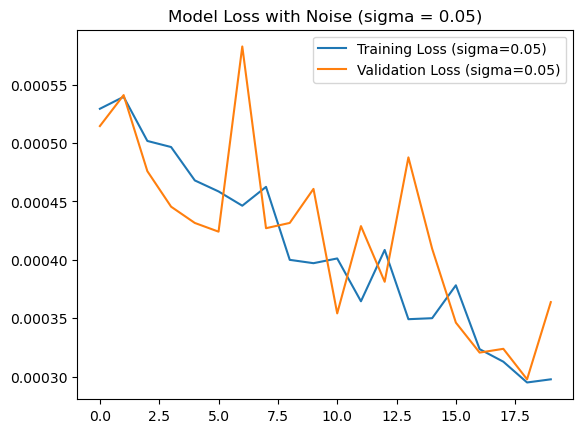

In [17]:
# Add noise with sigma = 0.05 to phi2 data
sigma = 0.05
noisy_phi2_005 = add_noise(phi2_masked, sigma)

# Split into training and testing sets for noisy data
X_train_005, X_test_005, y_train_005, y_test_005, masks_train_005, masks_test_005 = train_test_split(
    noisy_phi2_005, phi1_norm, masks, test_size=0.2, random_state=42
)

# Train the model
history_005 = model.fit(
    [X_train_005, masks_train_005], y_train_005,
    validation_data=([X_test_005, masks_test_005], y_test_005),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history_005.history['loss'], label='Training Loss (sigma=0.05)')
plt.plot(history_005.history['val_loss'], label='Validation Loss (sigma=0.05)')
plt.legend()
plt.title("Model Loss with Noise (sigma = 0.05)")
plt.show()


In [19]:
# Predict the output for the noisy input (sigma = 0.05)
predicted_phi1_005 = model.predict([X_test_005, masks_test_005])

# Calculate and display the metrics
def calculate_metrics(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    from skimage.metrics import structural_similarity as ssim
    import numpy as np

    # Flatten the images for metric calculations
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # 1. Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

    # 2. Calculate L∞ Error (Maximum absolute error)
    l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))

    # 3. Calculate SSIM (Structural Similarity Index)
    ssim_index = ssim(y_true[0].reshape(171, 171), y_pred[0].reshape(171, 171), data_range=1)

    # 4. Calculate L2 Error
    l2_error = np.linalg.norm(y_true_flat - y_pred_flat)

    # 5. Calculate Relative L2 Error
    true_l2_norm = np.linalg.norm(y_true_flat)
    relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

    return rmse, l_inf_error, ssim_index, l2_error, relative_l2_error

# Get the metrics for sigma = 0.05
rmse_005, l_inf_005, ssim_005, l2_005, relative_l2_005 = calculate_metrics(y_test_005, predicted_phi1_005)

# Print the results for sigma = 0.05
print(f"Sigma = 0.05:")
print(f"RMSE: {rmse_005}")
print(f"L∞ Error: {l_inf_005}")
print(f"SSIM: {ssim_005}")
print(f"L2 Error: {l2_005}")
print(f"Relative L2 Error: {relative_l2_005:.2f}%")  # Added percentage format
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
Sigma = 0.05:
RMSE: 0.0190747173581396
L∞ Error: 0.45199105397299966
SSIM: 0.9265096693085926
L2 Error: 53.29786991935991
Relative L2 Error: 4.48%
--------------------------------------------------


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 764ms/step - loss: 3.7253e-04 - val_loss: 3.5671e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 832ms/step - loss: 3.8526e-04 - val_loss: 3.4000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 688ms/step - loss: 3.5351e-04 - val_loss: 4.1702e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 637ms/step - loss: 3.9551e-04 - val_loss: 3.7111e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 628ms/step - loss: 3.4475e-04 - val_loss: 3.2315e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 597ms/step - loss: 3.3350e-04 - val_loss: 3.2874e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 583ms/step - loss: 3.3677e-04 - val_loss: 3.2367e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 671ms/step - loss: 3.1781e-04 - val_loss: 3.6730e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 677ms/step - loss: 3.3743e-04 - val_loss: 3.3747e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 649ms/step - loss: 3.2026e-04 - val_loss: 2.9835e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 604ms/

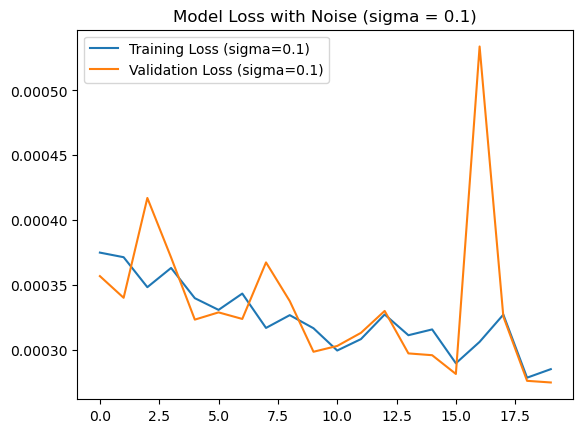

In [21]:
# Add noise with sigma = 0.1 to phi2 data
sigma = 0.1
noisy_phi2_010 = add_noise(phi2_masked, sigma)

# Split into training and testing sets for noisy data
X_train_010, X_test_010, y_train_010, y_test_010, masks_train_010, masks_test_010 = train_test_split(
    noisy_phi2_010, phi1_norm, masks, test_size=0.2, random_state=42
)

# Train the model
history_010 = model.fit(
    [X_train_010, masks_train_010], y_train_010,
    validation_data=([X_test_010, masks_test_010], y_test_010),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history_010.history['loss'], label='Training Loss (sigma=0.1)')
plt.plot(history_010.history['val_loss'], label='Validation Loss (sigma=0.1)')
plt.legend()
plt.title("Model Loss with Noise (sigma = 0.1)")
plt.show()


In [23]:
# Predict the output for the noisy input (sigma = 0.1)
predicted_phi1_010 = model.predict([X_test_010, masks_test_010])

# Calculate and display the metrics
def calculate_metrics(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    from skimage.metrics import structural_similarity as ssim
    import numpy as np

    # Flatten the images for metric calculations
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # 1. Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

    # 2. Calculate L∞ Error (Maximum absolute error)
    l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))

    # 3. Calculate SSIM (Structural Similarity Index)
    ssim_index = ssim(y_true[0].reshape(171, 171), y_pred[0].reshape(171, 171), data_range=1)

    # 4. Calculate L2 Error
    l2_error = np.linalg.norm(y_true_flat - y_pred_flat)

    # 5. Calculate Relative L2 Error
    true_l2_norm = np.linalg.norm(y_true_flat)
    relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

    return rmse, l_inf_error, ssim_index, l2_error, relative_l2_error

# Get the metrics for sigma = 0.1
rmse_010, l_inf_010, ssim_010, l2_010, relative_l2_010 = calculate_metrics(y_test_010, predicted_phi1_010)

# Print the results for sigma = 0.1
print(f"Sigma = 0.1:")
print(f"RMSE: {rmse_010}")
print(f"L∞ Error: {l_inf_010}")
print(f"SSIM: {ssim_010}")
print(f"L2 Error: {l2_010}")
print(f"Relative L2 Error: {relative_l2_010:.2f}%")  # Added percentage format
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
Sigma = 0.1:
RMSE: 0.016572491361011972
L∞ Error: 0.42738335948073936
SSIM: 0.9405993804592574
L2 Error: 46.30624256259337
Relative L2 Error: 3.89%
--------------------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


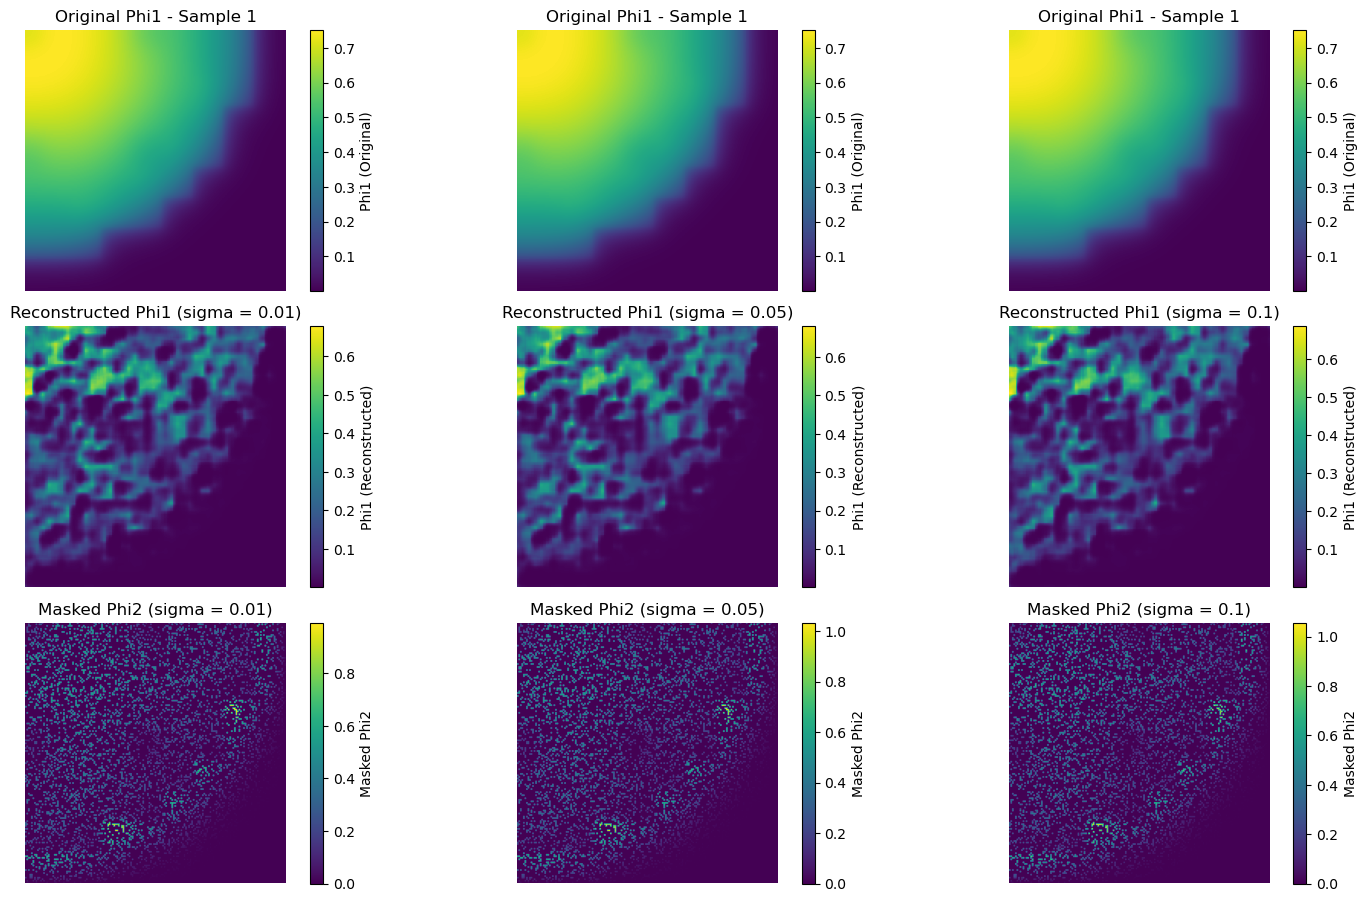

In [25]:
# Plot results for 1 sample for each sigma
n_samples = 1  # We'll just take 1 sample for comparison

plt.figure(figsize=(15, 12))

for idx, sigma in enumerate([0.01, 0.05, 0.1]):
    # Noisy Phi2 for the current sigma
    noisy_phi2_sample = noisy_phi2[sigma][0]  # Just the first sample (you can change the index for a different sample)
    
    # Predict Phi1 (Reconstructed) for the current sigma
    predicted_phi1 = model.predict([noisy_phi2_sample[np.newaxis], masks_test[0:1]])  # Adding batch dimension
    
    # Plot the results for each sigma
    # Original Phi1 (Ground truth)
    plt.subplot(4, 3, idx + 1)
    plt.imshow(y_test[0].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi1 (Original)')
    plt.title(f'Original Phi1 - Sample 1')
    plt.axis('off')

    # Reconstructed Phi1 (Predicted by the model)
    plt.subplot(4, 3, idx + 4)
    plt.imshow(predicted_phi1.squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi1 (Reconstructed)')
    plt.title(f'Reconstructed Phi1 (sigma = {sigma})')
    plt.axis('off')

    # Noisy Phi2 (Input to the model)
    plt.subplot(4, 3, idx + 7)
    plt.imshow(noisy_phi2_sample.squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 (sigma = {sigma})')
    plt.axis('off')

plt.tight_layout()
plt.show()


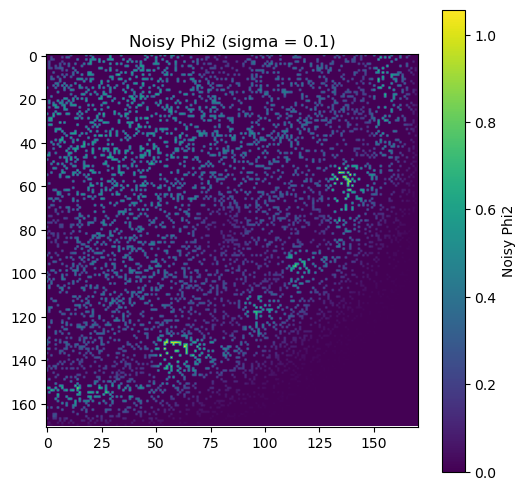

In [27]:
# Plot the noisy Phi2 for sigma = 0.1
plt.figure(figsize=(6, 6))
plt.imshow(noisy_phi2[0.1][0].squeeze(), cmap='viridis')
plt.colorbar(label="Noisy Phi2")
plt.title("Noisy Phi2 (sigma = 0.1)")
plt.show()


In [29]:
print("Predicted values range:", np.min(predicted_phi1_001), np.max(predicted_phi1_001))


Predicted values range: 0.00026639787 0.96572965


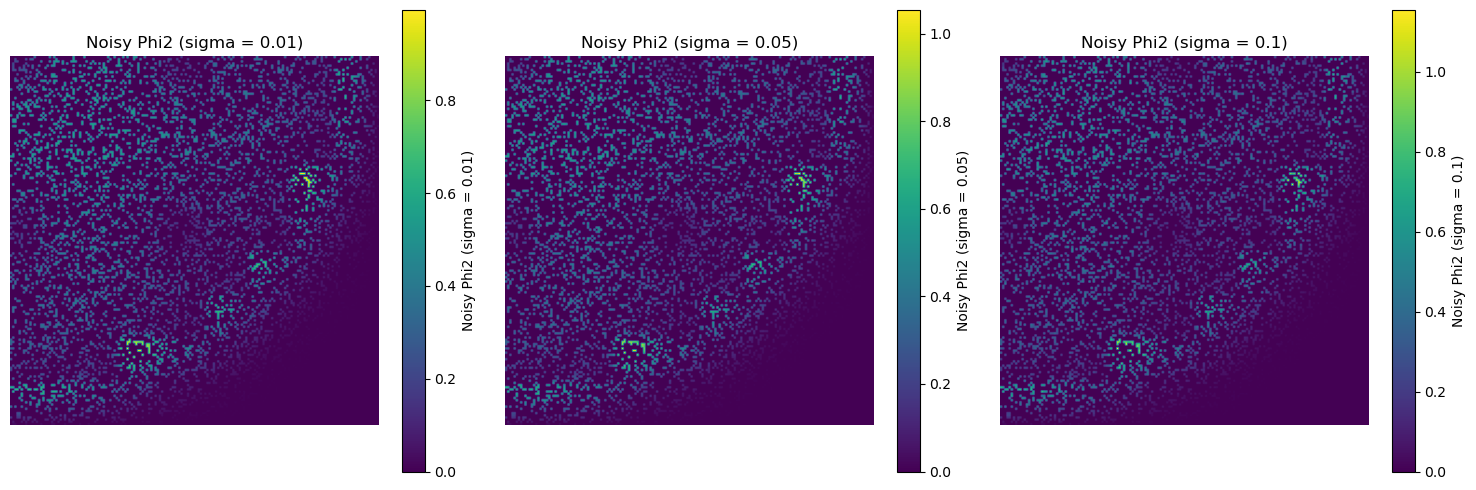

In [31]:
# Visualize noise for different sigma values
sigma_values = [0.01, 0.05, 0.1]
plt.figure(figsize=(15, 5))

for idx, sigma in enumerate(sigma_values):
    noise = np.random.normal(0, sigma, phi2_masked.shape)  # Generate noise for each sigma
    noisy_data = phi2_masked * (1 + noise)  # Apply the noise

    plt.subplot(1, 3, idx + 1)
    plt.imshow(noisy_data[0].squeeze(), cmap='viridis')
    plt.colorbar(label=f'Noisy Phi2 (sigma = {sigma})')
    plt.title(f'Noisy Phi2 (sigma = {sigma})')
    plt.axis('off')

plt.tight_layout()
plt.show()
